# **Forecasting Sticker Sales - Playgroud Series S5E1**

## **Importing Libraries**

In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import requests
import holidays

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


print("Libaries imported")

Libaries imported


## **Importing Data**

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")

train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

In [3]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


### **Adding GDP and Holidays**

In [4]:
def get_gdp_per_capita(country, year):
    alpha3 = {
        'Canada': 'CAN', 'Finland': 'FIN', 'Italy': 'ITA',
        'Kenya': 'KEN', 'Norway': 'NOR', 'Singapore': 'SGP'
    }
    url = f"https://api.worldbank.org/v2/country/{alpha3[country]}/indicator/NY.GDP.PCAP.CD?date={year}&format=json"
    response = requests.get(url).json()
    try:
        return response[1][0]['value']
    except (IndexError, TypeError):
        return None

countries = ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
years = range(2010, 2020)
gdp_data = {}

for country in countries:
    for year in years:
        gdp_data[(country, year)] = get_gdp_per_capita(country, year)

def add_gdp_feature(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year  
    df['gdp'] = df.apply(lambda row: gdp_data.get((row['country'], row['year']), None), axis=1)
    return df


def add_holiday_feature(df):
    country_holidays = {
        'Canada': holidays.CountryHoliday('CA'),
        'Finland': holidays.CountryHoliday('FI'),
        'Italy': holidays.CountryHoliday('IT'),
        'Kenya': holidays.CountryHoliday('KE'),
        'Norway': holidays.CountryHoliday('NO'),
        'Singapore': holidays.CountryHoliday('SG')
    }

    df['date'] = pd.to_datetime(df['date'])

    df['is_holiday'] = df.apply(
        lambda row: row['date'] in country_holidays.get(row['country'], []), axis=1
    )
    return df



train = add_holiday_feature(train)
test = add_holiday_feature(test)
train = add_gdp_feature(train)
test = add_gdp_feature(test)

In [5]:
train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'is_holiday',
       'year', 'gdp'],
      dtype='object')

In [6]:
train.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,country,store,product,num_sold,is_holiday,year,gdp
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,True,2010,47560.666601
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,True,2010,47560.666601
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,True,2010,47560.666601
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,True,2010,47560.666601
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,True,2010,47560.666601


### **Missing/Duplicate Data Check and Extracting Date Components**

In [7]:
train.isna().sum()

id               0
date             0
country          0
store            0
product          0
num_sold      8871
is_holiday       0
year             0
gdp              0
dtype: int64

In [8]:
train.duplicated().sum()

0

In [9]:
train = train.dropna(subset=['num_sold'])

for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    df['month_country'] = df['month'].astype(str) + "_" + df['country']
    df['month_store'] = df['month'].astype(str) + "_" + df['store']
    df['month_product'] = df['month'].astype(str) + "_" + df['product']

In [10]:
train['num_sold_log'] = np.log1p(train['num_sold'])  

X = train.drop(columns=['id', 'num_sold', 'num_sold_log', 'date'])
y = train['num_sold_log']

categorical_features = ['country', 'store', 'product', 'month_country', 'month_store', 'month_product']
numerical_features = ['gdp', 'year', 'month', 'day', 'day_of_week', 'is_weekend','is_holiday']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

In [11]:
model.fit(X, y)

test['num_sold'] = np.expm1(model.predict(test.drop(columns=['id', 'date'])))


submission = test[['id', 'num_sold']]
submission.to_csv("submission.csv", index=False)

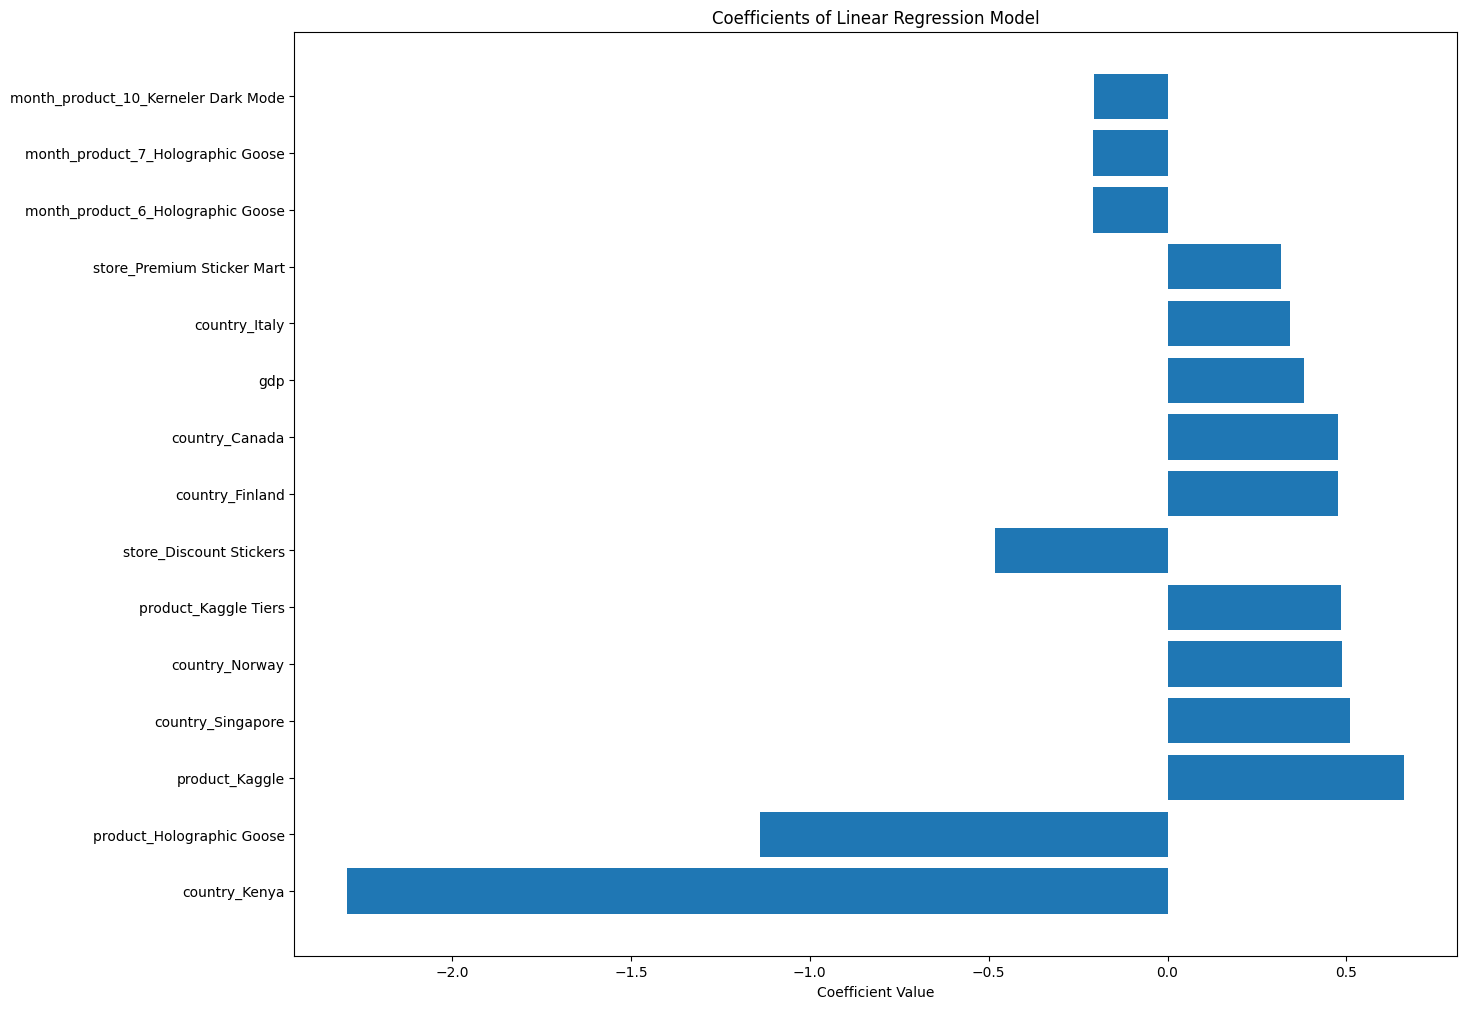

In [12]:
coefficients = model.named_steps['regressor'].coef_

cat_columns = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)

feature_names = numerical_features + list(cat_columns) 

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})


coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

top_coeff_df = coeff_df.head(15)

plt.figure(figsize=(15, 12))
plt.barh(top_coeff_df['Feature'], top_coeff_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Linear Regression Model')
plt.show()



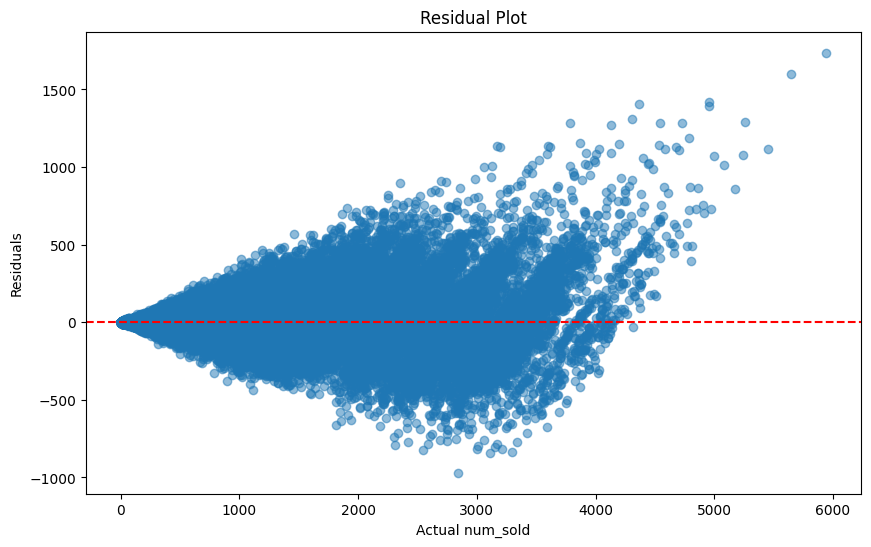

In [13]:
residuals = np.expm1(y) - np.expm1(model.predict(X))
plt.figure(figsize=(10, 6))
plt.scatter(np.expm1(y), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual num_sold")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [14]:
submission = test[['id', 'num_sold']]
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv
